In [4]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from IPython.display import Image

from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'
if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# Get list of all objects

In [5]:
cleardir = dpath +'CLEAR' # sets path to be $HOME/Data/CLEAR
# sets path to be $HOME/Data/CLEAR
# cleardir should include (available from the website): 
#    RELEASE_v1.0.0/
#    RELEASE_v1.0.0/CATALOGS/
# available from:  https://archive.stsci.edu/pub/clear_team/

threeddir = dpath + '3D-HST/CATALOGS'

# should include 
#    goodsn_3dhst.v4.1.cats/
#.      Catalog/                
#.      Eazy/ 
#       Fast/
#.      RF_colors/
#    goodss_3dhst.v4.1.cats/
#.      Catalog/                
#.      Eazy/ 
#       Fast/
#.      RF_colors/
# available from:  https://3dhst.research.yale.edu/Data.php


catdir = os.path.join(cleardir,'CATALOGS') 
# sets path for $HOME/Data/CLEAR/CATALOGS
# should include all files from CATALOGS/ directory at: 
#     https://archive.stsci.edu/pub/clear_team/CATALOGS/
#    

linedir = os.path.join(cleardir,'RELEASE_v1.0.0/CATALOGS')
# should include all files from RELEASE_v1.0.0/CATALOGS/ directory at:
#.    https://archive.stsci.edu/pub/clear_team/RELEASE_v1.0.0/CATALOGS/

combineddir = os.path.join(cleardir,'RELEASE_v1.0.0/COMBINED')
# shoudl include all files from https://archive.stsci.edu/pub/clear_team/RELEASE_v1.0.0/
# download the tar.gz files and untar them - I sent a .sh script that has suggested ways to download everything.

In [6]:
### Check that all the directories we just set up do exist:

for d in [cleardir, catdir, linedir, threeddir,combineddir] :
    if os.path.exists(d) : print ("EXISTS: %s" % d)
    else : print("DOES NOT EXIST: %s" %  d)


EXISTS: /Volumes/Vince_research/Data/CLEAR
EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS
EXISTS: /Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/CATALOGS
EXISTS: /Volumes/Vince_research/Data/3D-HST/CATALOGS
EXISTS: /Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/COMBINED


In [7]:
gndfile = os.path.join(catdir,'goodsn_3dhst.v4.3.cat')
gndzoutfile = os.path.join(catdir,'goodsn_v4.3.zout')
gndlinefile = os.path.join(linedir,'GN_CLEAR.linefit.concat.v1.0.0.fits')
gndzfitfile = os.path.join(linedir,'GN_CLEAR.zfit.concat.v1.0.0.fits')
gndfoutfile = os.path.join(catdir,'goodsn_v4.3.fout')

# all need to exist:
for file in [gndfile, gndzoutfile, gndlinefile, gndzfitfile,gndfoutfile] : 
    if os.path.exists(file) : print ("EXISTS: %s" % file)
    else: print("DOES NOT EXIST: %s" %  d)

EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_3dhst.v4.3.cat
EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.3.zout
EXISTS: /Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.linefit.concat.v1.0.0.fits
EXISTS: /Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.zfit.concat.v1.0.0.fits
EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.3.fout


In [8]:
gsdfile = os.path.join(catdir,'goodss_3dhst.v4.3.cat')
gsdzoutfile = os.path.join(catdir,'goodss_v4.3.zout')
gsdlinefile = os.path.join(linedir,'GS_CLEAR.linefit.concat.v1.0.0.fits')
gsdzfitfile = os.path.join(linedir,'GS_CLEAR.zfit.concat.v1.0.0.fits')
gsdfoutfile = os.path.join(catdir,'goodss_v4.3.fout')
#gsdfoutfile = os.path.join(threeddir,'goodss_3dhst.v4.1.cats/','Fast','goodss_3dhst.v4.1.fout')

for file in [gndfile, gndzoutfile, gndlinefile, gndzfitfile,gndfoutfile] : 
    if os.path.exists(file) : print ("EXISTS: %s" % file)
    else: print("DOES NOT EXIST: %s" %  d)

EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_3dhst.v4.3.cat
EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.3.zout
EXISTS: /Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.linefit.concat.v1.0.0.fits
EXISTS: /Volumes/Vince_research/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.zfit.concat.v1.0.0.fits
EXISTS: /Volumes/Vince_research/Data/CLEAR/CATALOGS/goodsn_v4.3.fout


In [9]:
# define a routine to read in all the catalogs: 
def loadclear( catfile, zoutfile, foutfile, zfitfile, linefile, doprint=False) : 

    cat = Table.read(catfile, format='ascii').to_pandas()
    zcat = Table.read(zoutfile, format='ascii').to_pandas()
    fcat = Table.read(foutfile, format='ascii').to_pandas()
    
    zfitcat = Table.read(zfitfile).to_pandas()
    linecat = Table.read(linefile).to_pandas()
    
    return(cat, zcat, fcat, zfitcat, linecat)

In [10]:
gnd, gndz, gndf, gndzfit, gndline = loadclear(gndfile, gndzoutfile, gndfoutfile, 
                                              gndzfitfile, gndlinefile)
gsd, gsdz, gsdf, gsdzfit, gsdline = loadclear(gsdfile, gsdzoutfile, gsdfoutfile, 
                                              gsdzfitfile, gsdlinefile)

In [11]:
# could use pd.concat, but this matches line-by-line
# gsddf = pd.concat([gsd,gsdz],axis=1) 
#gsddf = pd.concat([gsddf,gsdf],axis=1)
# default is join='outer', which pads cells with NaNs (that's what you want)  
# join='inner' only keeps rows that are in both catalogs. 
# the axis=1 means to match by ID number
#
# The only caveat is if columns in the different dataframes have the same column name - not sure what happens then.
#display(gnddf)

# INSTEAD:  here we use PANDAS MERGE routine to match based on keys (on="key") that are the name of the columns.

def domerge(gnd, gndz, gndf, gndzfit, gndlinefit) : 
    # add 'id' to zfit and linefit so we can key off those. 
    # could also use .merge(left, right, left_on='phot_id', right_on='id').... 
    gndzfit['id'] = gndzfit['phot_id']
    gndlinefit['id'] = gndlinefit['phot_id']
    # 
    
    gnddf = gndzfit
    print("Initial number of objects with grism zfits: %i" % len(gnddf))


    for f in [gnd, gndz, gndf, gndlinefit] : 
        gnddf = pd.merge(gnddf,f,on='id',how='inner')

    print("Final number (includes objects with different line identifications: %i" % len(gnddf))
    print()
    return(gnddf)

print("The reason there are more objects in the final than initial is that about ~100 objects fall in regions of overlap between CLEAR fields\n ")
gnddf = domerge(gnd,gndz,gndf, gndzfit, gndline)
gsddf = domerge(gsd,gsdz,gsdf, gsdzfit, gsdline)

The reason there are more objects in the final than initial is that about ~100 objects fall in regions of overlap between CLEAR fields
 
Initial number of objects with grism zfits: 2139
Final number (includes objects with different line identifications: 2337

Initial number of objects with grism zfits: 1792
Final number (includes objects with different line identifications: 1862



In [12]:
# Let's look at the Duplicates - 
# this only finds objects that have the same "phot_id" and lists them:
gnddf = gnddf.drop_duplicates(subset=['id','grism_id_x'])
gsddf = gsddf.drop_duplicates(subset=['id','grism_id_x'])

In [13]:
gndfastfile = os.path.join(threeddir,
                           'goodsn_3dhst.v4.1.cats','Fast',
                           'goodsn_3dhst.v4.1.fout')
gsdfastfile = os.path.join(threeddir,
                           'goodss_3dhst.v4.1.cats','Fast',
                           'goodss_3dhst.v4.1.fout')

gndRFcfile = os.path.join(threeddir,
                           'goodsn_3dhst.v4.1.cats','RF_colors',
                           'goodsn_3dhst.v4.1.master.RF')
gsdRFcfile = os.path.join(threeddir,
                           'goodss_3dhst.v4.1.cats','RF_colors',
                           'goodss_3dhst.v4.1.master.RF')

gndfast = Table.read(gndfastfile,format = 'ascii').to_pandas()
gsdfast = Table.read(gsdfastfile,format = 'ascii').to_pandas()
gndrfc = Table.read(gndRFcfile,format = 'ascii').to_pandas()
gsdrfc = Table.read(gsdRFcfile,format = 'ascii').to_pandas()

In [14]:
gndmaster = gnddf.merge(gndfast,on='id').merge(gndrfc,on='id').sort_values('id')
gsdmaster = gsddf.merge(gsdfast,on='id').merge(gsdrfc,on='id').sort_values('id')

In [15]:
gndmaster.to_pickle('../dataframes/gndmaster.pkl')
gsdmaster.to_pickle('../dataframes/gsdmaster.pkl')

# Source Selection

In [12]:
gndsamp = gndmaster.query('z_max_grism_x > 1.5 and lmass_y >= 10.0 and class_star < 0.8').drop_duplicates(subset=['id'])
gsdsamp = gsdmaster.query('z_max_grism_x > 1.5 and lmass_y >= 10.0 and class_star < 0.8').drop_duplicates(subset=['id'])

In [17]:
# gndsamp = gndmaster.query('2 < z_max_grism_x < 2.5 and lmass_y >= 10.5 and class_star < 0.8').drop_duplicates(subset=['id'])
# gsdsamp = gsdmaster.query('2 < z_max_grism_x < 2.5 and lmass_y >= 10.5 and class_star < 0.8').drop_duplicates(subset=['id'])

In [13]:
len(gndsamp) + len(gsdsamp)

265

In [14]:
(33 / 12 * 2) / np.sqrt(12) * np.sqrt(40)

10.041580220928045

In [15]:
34+183+10

227

In [16]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

UV_all = []
VJ_all = []

for i in gndfast.index:
    if 0.45 < gndfast.z[i] < 2.05 and gndfast.lmass[i] >= 10.0:
        UV_all.append(Color(gndrfc.L153[i],gndrfc.L155[i]))
        VJ_all.append(Color(gndrfc.L155[i],gndrfc.L161[i]))

for i in gsdfast.index:
    if 0.45 < gsdfast.z[i] < 2.05 and gsdfast.lmass[i] >= 10.0:
        UV_all.append(Color(gsdrfc.L153[i],gsdrfc.L155[i]))
        VJ_all.append(Color(gsdrfc.L155[i],gsdrfc.L161[i]))

gndsamp['UVJ'] = np.repeat('U',len(gndsamp))       
gsdsamp['UVJ'] = np.repeat('U',len(gsdsamp))       
     
for i in gndsamp.index:
    uv = Color(gndsamp.L153[i],gndsamp.L155[i])
    vj = Color(gndsamp.L155[i],gndsamp.L161[i])
    if uv>=0.88*vj+0.59 and uv>1.382 and vj<1.65:
        gndsamp['UVJ'][i] = 'Q'
    if uv<0.88*vj+0.59:
        gndsamp['UVJ'][i] = 'S'

for i in gsdsamp.index:
    uv = Color(gsdsamp.L153[i],gsdsamp.L155[i])
    vj = Color(gsdsamp.L155[i],gsdsamp.L161[i])
    if uv>=0.88*vj+0.59 and uv>1.382 and vj<1.65:
        gsdsamp['UVJ'][i] = 'Q'
    if uv<0.88*vj+0.59:
        gsdsamp['UVJ'][i] = 'S'
    

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packa

No handles with labels found to put in legend.


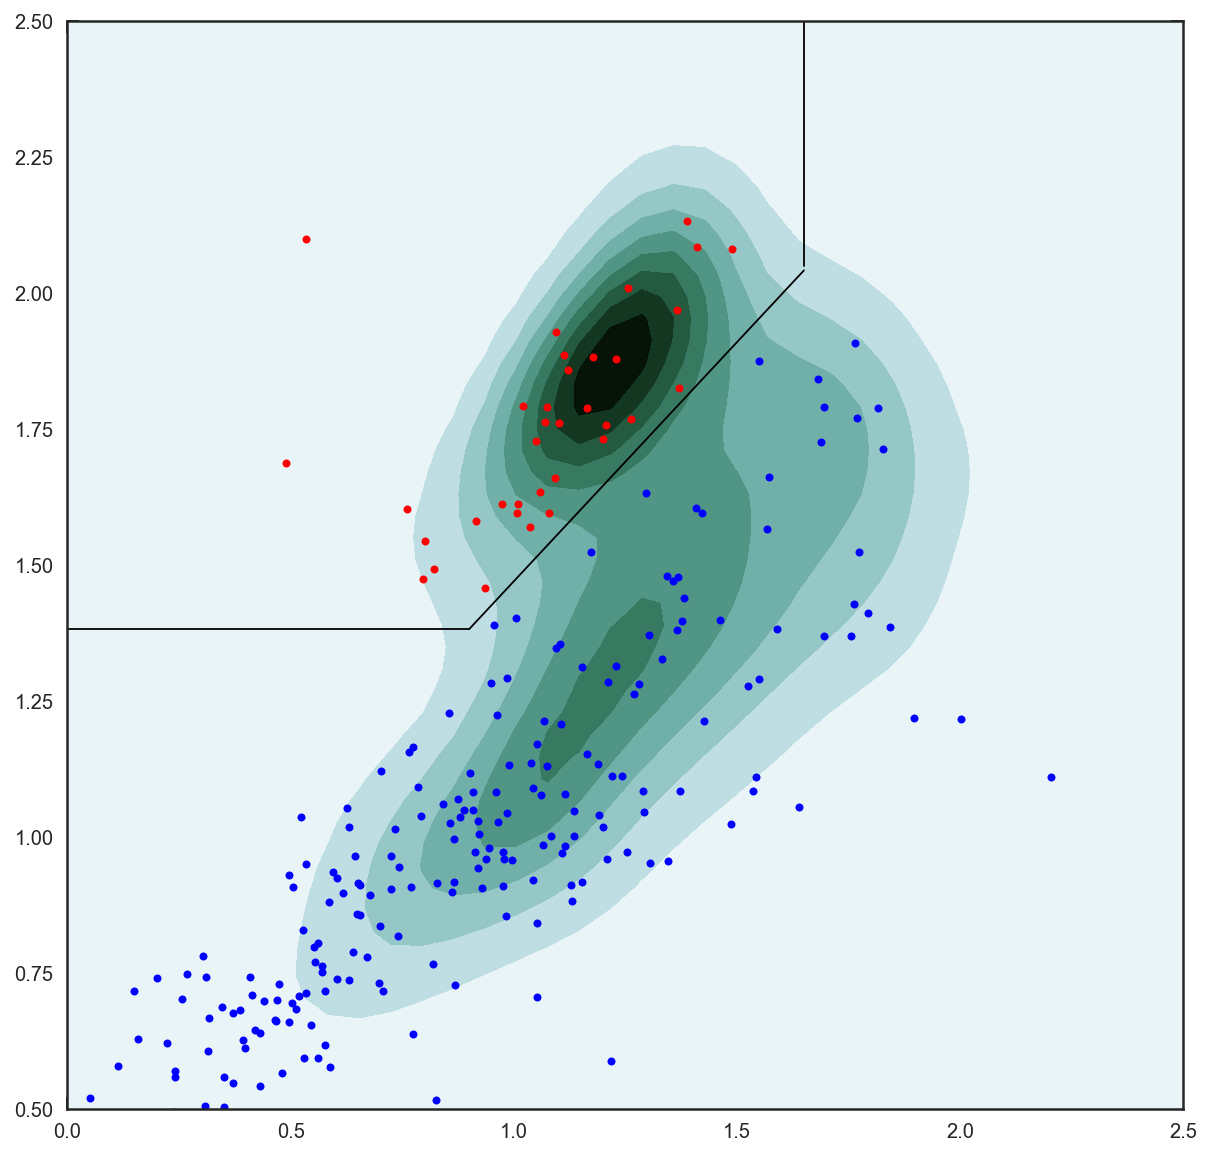

In [17]:
plt.figure(figsize=[10,10])
sea.kdeplot(VJ_all,UV_all,kernel='epa',shade=True,cmap=cmap)
plt.plot(Color(gndsamp.query('UVJ == "Q"').L155.values,gndsamp.query('UVJ == "Q"').L161.values),
         Color(gndsamp.query('UVJ == "Q"').L153.values,gndsamp.query('UVJ == "Q"').L155.values),'ro',ms=4)
plt.plot(Color(gsdsamp.query('UVJ == "Q"').L155.values,gsdsamp.query('UVJ == "Q"').L161.values),
         Color(gsdsamp.query('UVJ == "Q"').L153.values,gsdsamp.query('UVJ == "Q"').L155.values),'ro',ms=4)

plt.plot(Color(gndsamp.query('UVJ == "S"').L155.values,gndsamp.query('UVJ == "S"').L161.values),
         Color(gndsamp.query('UVJ == "S"').L153.values,gndsamp.query('UVJ == "S"').L155.values),'bo',ms=4)
plt.plot(Color(gsdsamp.query('UVJ == "S"').L155.values,gsdsamp.query('UVJ == "S"').L161.values),
         Color(gsdsamp.query('UVJ == "S"').L153.values,gsdsamp.query('UVJ == "S"').L155.values),'bo',ms=4)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()


In [18]:
print('Star-forming N = {0}'.format(len(gsdsamp.query('UVJ == "S"')) + len(gndsamp.query('UVJ == "S"'))))
print('Quiescent N = {0}'.format(len(gsdsamp.query('UVJ == "Q"')) + len(gndsamp.query('UVJ == "Q"'))))

Star-forming N = 221
Quiescent N = 35


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


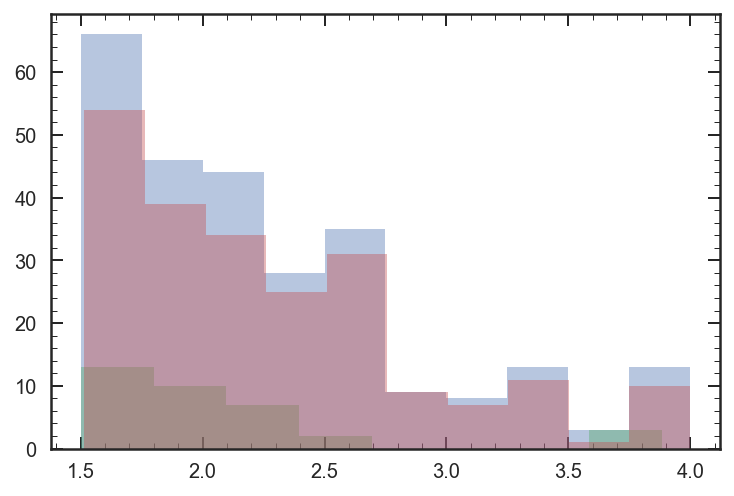

In [19]:
sea.distplot(np.append(gsdsamp.z_max_grism_x.values,gndsamp.z_max_grism_x.values),kde=False)
sea.distplot(np.append(gsdsamp.query('UVJ == "Q"').z_max_grism_x.values,gndsamp.query('UVJ == "Q"').z_max_grism_x.values),kde=False)
sea.distplot(np.append(gsdsamp.query('UVJ == "S"').z_max_grism_x.values,gndsamp.query('UVJ == "S"').z_max_grism_x.values),kde=False)

In [20]:
gsdsamp.query('UVJ == "Q"')#, gndsamp.query('UVJ == "Q"')

,phot_id_x,grism_id_x,jh_mag_x,z_spec_x,z_peak_phot,z_phot_l95,z_phot_l68,z_phot_u68,z_phot_u95,z_max_grism_x,...,n_271,L272,n_272,L273,n_273,L274,n_274,L275,n_275,UVJ
139,26272,b'GS4-G102_26272',22.751,-1.000,1.5313,1.430,1.478,1.586,1.642,1.5434,...,28,0.128131,28,0.268388,28,0.305359,28,8.30583,6,Q
680,29257,b'GS4-G102_29257',23.318,-1.000,1.6039,1.430,1.544,1.661,1.724,1.6393,...,28,0.201705,28,0.314958,29,0.339811,31,5.71485,6,Q
903,36095,b'GS3-G102_36095',21.417,-1.000,1.9536,1.888,1.920,1.987,2.015,1.9476,...,28,1.353240,28,2.074530,31,2.204460,32,38.10630,8,Q
359,38843,b'GS5-G102_38843',22.964,-1.000,1.6311,1.543,1.579,1.686,1.721,1.5294,...,28,0.167982,28,0.391517,29,0.450130,31,8.31035,6,Q
1602,39012,b'ERSPRIME-G102_39012',22.311,-1.000,1.5764,1.508,1.539,1.611,1.652,1.6117,...,28,0.103990,28,0.272681,28,0.314029,31,14.71080,6,Q
1683,39364,b'ERSPRIME-G102_39364',21.299,-1.000,1.6535,1.591,1.616,1.692,1.716,1.6078,...,28,1.177750,28,2.190460,30,2.447330,31,37.69070,6,Q
303,40223,b'GS5-G102_40223',22.548,-1.000,1.6111,1.558,1.581,1.642,1.665,1.5922,...,28,0.179707,28,0.417178,28,0.486177,31,12.22330,6,Q
958,41520,b'GS3-G102_41520',22.013,-1.000,1.6205,1.579,1.596,1.646,1.664,1.6039,...,28,0.214825,28,0.554250,28,0.649462,29,20.06920,6,Q
693,41886,b'GS5-G102_41886',22.800,2.090,2.1359,2.089,2.107,2.165,2.192,2.0603,...,28,0.948473,31,1.297600,32,1.398940,32,14.28800,8,Q
97,42113,b'GS3-G102_42113',21.427,-1.000,1.6176,1.577,1.593,1.642,1.664,1.6130,...,28,0.325174,28,0.885000,28,1.017520,31,33.78070,6,Q


In [21]:
gndsamp.query('UVJ == "Q"')

,phot_id_x,grism_id_x,jh_mag_x,z_spec_x,z_peak_phot,z_phot_l95,z_phot_l68,z_phot_u68,z_phot_u95,z_max_grism_x,...,n_271,L272,n_272,L273,n_273,L274,n_274,L275,n_275,UVJ
1168,14140,b'GN7-G102_14140',21.853,-1.0,1.6775,1.587,1.628,1.726,1.767,1.8349,...,12.0,0.404704,12.0,0.865218,13.0,0.982766,14.0,22.35410,5.0,Q
1120,15976,b'GN7-G102_15976',23.452,-1.0,2.3387,2.084,2.252,2.432,2.496,2.1283,...,12.0,0.437132,14.0,0.673639,15.0,0.719555,15.0,8.53498,6.0,Q
1869,21427,b'GN4-G102_21427',21.857,-1.0,1.4738,1.395,1.430,1.517,1.552,1.5018,...,10.0,0.308952,12.0,0.702919,12.0,0.813474,12.0,18.97240,7.0,Q
1818,21738,b'GN2-G102_21738',22.756,-1.0,2.0362,1.885,1.958,2.108,2.157,2.1158,...,12.0,0.159133,14.0,0.438265,15.0,0.515992,14.0,16.10000,6.0,Q
646,23018,b'GN4-G102_23018',22.460,-1.0,2.0393,1.925,1.967,2.120,2.219,2.2740,...,12.0,1.039650,14.0,1.449090,15.0,1.522850,14.0,18.21190,6.0,Q
472,33780,b'GN5-G102_33780',21.753,-1.0,1.8039,1.679,1.733,1.872,1.931,1.8648,...,12.0,0.280683,12.0,0.706714,14.0,0.811919,14.0,29.71660,6.0,Q
1301,35469,b'GN3-G102_35469',22.731,-1.0,1.7846,1.675,1.727,1.856,1.926,1.9639,...,12.0,0.341194,12.0,0.633854,14.0,0.700478,14.0,10.69610,6.0,Q
2121,36672,b'GN5-G102_36672',24.549,-1.0,3.1710,2.985,3.076,3.270,3.366,3.6297,...,15.0,1.374330,17.0,1.491540,14.0,1.489590,13.0,13.24740,2.0,Q
1224,37896,b'GN1-G102_37896',23.670,-1.0,1.5763,1.358,1.450,1.712,1.805,1.8221,...,12.0,0.069792,12.0,0.145160,12.0,0.164348,12.0,3.89885,5.0,Q
1894,37901,b'GN1-G102_37901',24.738,-1.0,4.3062,4.076,4.195,4.415,4.478,3.8842,...,17.0,1.751140,17.0,1.878900,14.0,1.876790,13.0,10.46420,2.0,Q


In [22]:
gsdsamp.query('UVJ == "Q"').to_pickle('../dataframes/clear_q_gsd.pkl')

In [23]:
gndsamp.query('UVJ == "Q"').to_pickle('../dataframes/clear_q_gnd.pkl')

In [198]:
tok = (gndsamp['Hb_EQW'] > 10) & (gndsamp['OIII_EQW'] > 40) & \
    (gndsamp['Hb_EQW']/gndsamp['Hb_EQW_ERR'] > 3) & \
    (gndsamp['OIII_EQW']/gndsamp['OIII_EQW_ERR'] > 3)
print("There are %d objects which fit these criteria" % (np.sum(tok)))
pd.options.display.max_rows=9999
display(gndsamp.loc[tok])
pd.options.display.max_rows=10
# print(tok)

There are 13 objects which fit these criteria


,phot_id_x,grism_id_x,jh_mag_x,z_spec_x,z_peak_phot,z_phot_l95,z_phot_l68,z_phot_u68,z_phot_u95,z_max_grism_x,...,n_271,L272,n_272,L273,n_273,L274,n_274,L275,n_275,UVJ
1048,14850,b'GN7-G102_14850',21.559,1.2230,1.1634,1.128,1.140,1.188,1.210,1.2200,...,10.0,3.565780,12.0,4.866590,12.0,5.080940,12.0,20.56650,7.0,S
990,18224,b'GN2-G102_18224',20.108,0.9610,1.0143,0.996,1.000,1.028,1.034,0.9591,...,8.0,4.427260,10.0,6.965960,12.0,7.556840,12.0,68.50810,7.0,S
800,22815,b'GN4-G102_22815',20.978,0.8390,0.8650,0.828,0.843,0.888,0.907,0.8432,...,7.0,6.154810,8.0,7.771520,10.0,8.007720,10.0,29.77520,8.0,S
1196,26193,b'GN4-G102_26193',21.287,0.9140,0.8490,0.818,0.829,0.870,0.887,0.9175,...,7.0,2.237580,10.0,3.297660,10.0,3.505860,12.0,17.67430,7.0,S
897,30588,b'GN5-G102_30588',20.219,-1.0000,0.2996,0.287,0.291,0.309,0.312,0.7083,...,4.0,3.575660,6.0,4.628550,8.0,4.859160,8.0,36.45820,7.0,S
81,31245,b'GN3-G102_31245',21.127,0.9050,0.9382,0.897,0.909,0.969,0.987,0.9079,...,7.0,5.225430,10.0,6.658530,10.0,6.859940,12.0,25.66300,7.0,S
831,34251,b'GN5-G102_34251',21.939,-1.0000,1.2825,1.136,1.273,1.315,1.327,1.2558,...,10.0,1.554710,12.0,2.074540,12.0,2.177070,12.0,14.23990,7.0,S
307,34708,b'GN3-G102_34708',21.202,1.0285,0.9591,0.923,0.940,0.978,0.992,0.9367,...,8.0,5.774960,10.0,7.520290,12.0,7.800370,12.0,28.27290,8.0,S
142,34747,b'GN5-G102_34747',22.548,-1.0000,0.8836,0.799,0.831,0.946,1.029,1.1522,...,8.0,0.263000,10.0,0.499846,12.0,0.551624,12.0,6.71828,7.0,S
447,35090,b'GN3-G102_35090',20.041,-1.0000,0.9628,0.917,0.940,0.984,0.994,0.9868,...,8.0,1.750440,10.0,2.813960,12.0,3.034970,12.0,60.88090,7.0,Q


In [28]:
SearchID = 26272

files_all = glob('%s/*/*/*%s*' % (combineddir, SearchID))

print('There are a total of %d files for the combined spectrum of this object.' % (len(files_all)))

There are a total of 15 files for the combined spectrum of this object.


In [29]:
files_png = glob('%s/*/*/*%s*.png' % (combineddir, SearchID))
print('Found %d PNG files.' % len(files_png))
for file in files_png:
    print(file)

Found 7 PNG files.
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/1D/PNG/GS4-G102_26272.1D.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/2D/PNG/GS4-G102_26272_stack.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/LINEFIT/CHAIN_PNG/GS4-G102_26272.linefit.chain.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/LINEFIT/PNG/GS4-G102_26272.linefit.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/ZFIT/2D_FITS/GS4-G102_26272.new_zfit.2D.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/ZFIT/PNG/GS4-G102_26272.new_zfit.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/ZFIT/TILT_PNG/GS4-G102_26272.new_zfit_tilt.png


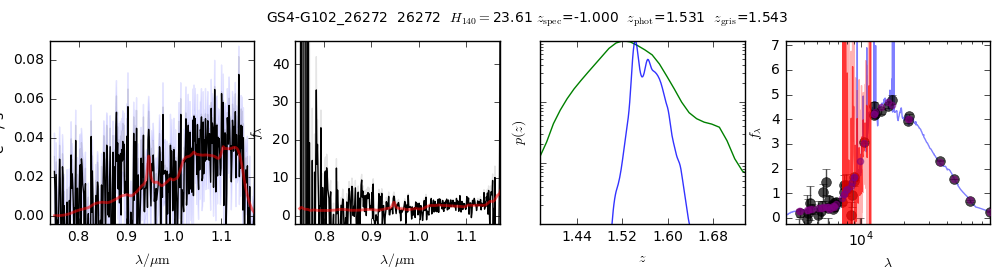

In [36]:
Image(files_png[5])

In [13]:
filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
for i in s_cand_sup.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand_sup.ra[i],s_cand_sup.dec[i])
        if pres == True:
            s_cand_sup.in_out[i]= 'in'
            break
            
filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
for i in n_cand_sup.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand_sup.ra[i],n_cand_sup.dec[i])
        if pres == True:
            n_cand_sup.in_out[i]= 'in'
            break

            
filelist = glob(hpath + 'UDS_data/uds_flt_files/*flt.fits')
for i in u_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],u_cand.ra[i],u_cand.dec[i])
        if pres == True:
            u_cand.in_out[i]= 'in'
            break

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
s_cand_sup = s_cand_sup.query('in_out == "in"')
n_cand_sup = n_cand_sup.query('in_out == "in"')
u_cand = u_cand.query('in_out == "in"')

In [30]:
s_cand_sup.to_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup.to_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand.to_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [2]:
s_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand= pd.read_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [25]:
s_in_out = np.repeat('out',len(s_cand_sup.index))
filelist = glob(hpath + '3dhst/s_flt_files/*flt.fits')
for i in range(len(s_cand_sup.index)):
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand_sup.ra[s_cand_sup.index[i]],s_cand_sup.dec[s_cand_sup.index[i]])
        if pres == True:
            s_in_out[i]= 'in'
            break
            
n_in_out = np.repeat('out',len(n_cand_sup.index))          
filelist = glob(hpath + '/3dhst/n_flt_files/*flt.fits')
for i in range(len(n_cand_sup.index)):
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand_sup.ra[n_cand_sup.index[i]],n_cand_sup.dec[n_cand_sup.index[i]])
        if pres == True:
            n_in_out[i]= 'in'
            break

u_in_out = np.repeat('out',len(u_cand.index))                  
filelist = glob(hpath + 'UDS_data/uds_g141_flts/*flt.fits')
for i in range(len(u_cand.index)):
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],u_cand.ra[u_cand.index[i]],u_cand.dec[u_cand.index[i]])
        if pres == True:
            u_in_out[i]= 'in'
            break

In [29]:
s_cand_sup.in_out = s_in_out
n_cand_sup.in_out = n_in_out
u_cand.in_out = u_in_out

# remove AGN

In [3]:
s_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand= pd.read_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [4]:
agn_ra=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_RA']
agn_dec=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_DEC']

In [18]:
def Match_agn(gal_ra, gal_dec, agn_ra, agn_dec):
    r = (1. / 60 / 60) * 1    
    in_out = np.repeat('in',len(gal_ra))          
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(agn_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(agn_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(agn_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                in_out[i]= 'out'
    return in_out

In [19]:
south_agn = Match_agn(s_cand_sup['ra'].values,s_cand_sup['dec'].values,agn_ra,agn_dec)

In [21]:
n_agn_cat=Table.read('../../../Clear_data/AGN_catalog/apjs523032t3_mrt.txt',format='ascii')

In [22]:
RA=np.array([n_agn_cat['RAh'].data, n_agn_cat['RAm'].data,n_agn_cat['RAs'].data]).T
DEC=np.array([n_agn_cat['DEd'].data,n_agn_cat['DEm'].data,n_agn_cat['DEs'].data]).T

def Convert_RA_DEC_to_deg(ra,dec):
    R=15*(ra[0]+ra[1]/60.+ra[2]/3600.)
    D=dec[0]+dec[1]/60.+dec[2]/3600.
    return R,D

nra,ndec=np.zeros([2,len(RA)])

for i in range(len(RA)):
    nra[i],ndec[i]=Convert_RA_DEC_to_deg(RA[i],DEC[i])

In [23]:
north_agn = Match_agn(n_cand_sup['ra'].values,n_cand_sup['dec'].values,nra,ndec)

In [25]:
s_cand_sup.in_out = south_agn
n_cand_sup.in_out = north_agn

In [26]:
s_cand_sup = s_cand_sup.query('in_out == "in"')
n_cand_sup = n_cand_sup.query('in_out == "in"')

In [27]:
s_cand_sup.to_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup.to_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')

## Extra objects

In [2]:
goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

if hpath == '/Users/Vince.ec/':
    catpath = hpath
else:
    catpath='/Users/vestrada/Desktop/'

restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

fast_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
fast_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

eazy_s = Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()
eazy_n = Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()

In [3]:
IDS=[]
IDN=[]


for i in range(len(restc_s['id'])):
    if eazy_s.z_spec[i] != -1:
        rshift = eazy_s.z_spec[i]
    else: 
        rshift = eazy_s.z_peak[i]

    if rshift >= 1.4 and goods_s['class_star'][i]<0.8 and fast_s['lmass'][i] >= 10:
        IDS.append(i)

for i in range(len(restc_n['id'])):
    if eazy_n.z_spec[i] != -1:
        rshift = eazy_n.z_spec[i]
    else: 
        rshift = eazy_n.z_peak[i]

    if rshift >= 1.4 and goods_n['class_star'][i]<0.8 and fast_n['lmass'][i] >= 10:
        IDN.append(i)

In [4]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)
uvN=Mag(restc_n['L153'][IDN].values) - Mag(restc_n['L155'][IDN].values)
vjN=Mag(restc_n['L155'][IDN].values) - Mag(restc_n['L161'][IDN].values)
dustS = fast_s['Av'][IDS].values
dustN = fast_n['Av'][IDN].values

IDSQ=[]
IDSsf=[]

IDNQ=[]
IDNsf=[]


for i in range(len(uvS)):
    if uvS[i]>=0.88*vjS[i]+0.59 and uvS[i]>1.382 and vjS[i]<1.65:
        IDSQ.append(i)
    if uvS[i]<0.88*vjS[i]+0.59:
        IDSsf.append(i)
        
for i in range(len(uvN)):
    if uvN[i]>=0.88*vjN[i]+0.59 and uvN[i]>1.382 and vjN[i]<1.65:
        IDNQ.append(i)
    if uvN[i]<0.88*vjN[i]+0.59:
        IDNsf.append(i)

No handles with labels found to put in legend.


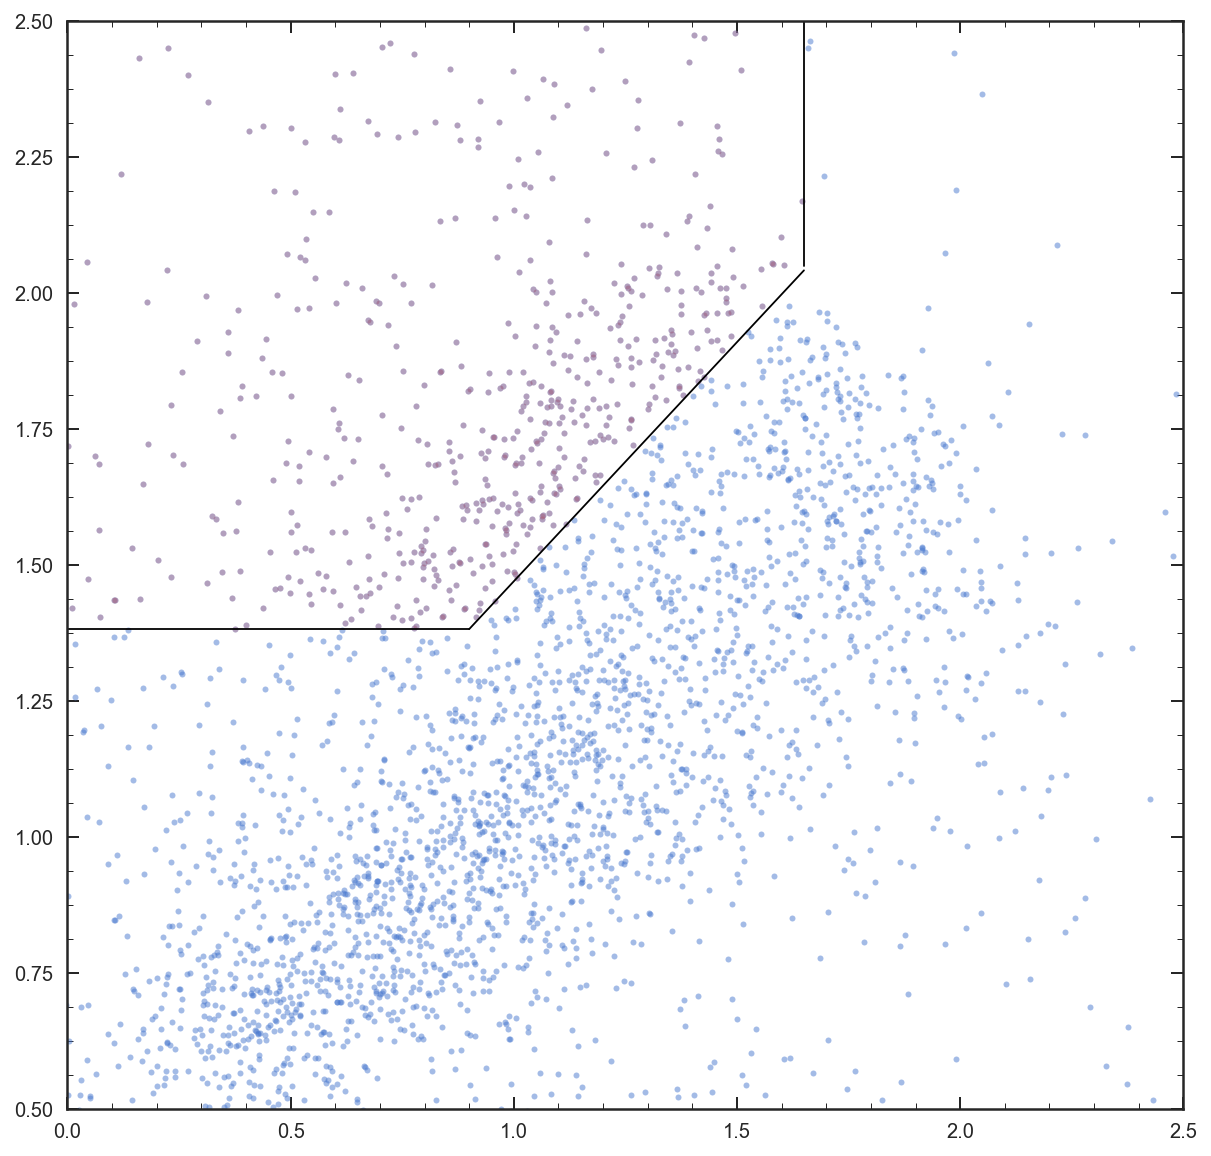

In [5]:
plt.figure(figsize=[10,10])
plt.plot(vjS,uvS,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjN,uvN,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjS[IDSQ],uvS[IDSQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot(vjN[IDNQ],uvN[IDNQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()

In [6]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 <pos[0]< xpixlim + 100  and -100 < pos[1] < ypixlim + 100 and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [7]:
s_cand =pd.DataFrame({ 'gids' : eazy_s.id[np.array(IDS)[np.array(IDSQ)]],
    'zspec' : eazy_s.z_spec[np.array(IDS)[np.array(IDSQ)]],
    'zphot' : eazy_s.z_peak[np.array(IDS)[np.array(IDSQ)]],
    'ra' : goods_s.ra[np.array(IDS)[np.array(IDSQ)]],
    'dec' : goods_s.dec[np.array(IDS)[np.array(IDSQ)]],
    'in_out' : np.repeat('out',len(IDSQ))})

n_cand =pd.DataFrame({ 'gids' : eazy_n.id[np.array(IDN)[np.array(IDNQ)]],
    'zspec' : eazy_n.z_spec[np.array(IDN)[np.array(IDNQ)]],
    'zphot' : eazy_n.z_peak[np.array(IDN)[np.array(IDNQ)]],
    'ra' : goods_n.ra[np.array(IDN)[np.array(IDNQ)]],
    'dec' : goods_n.dec[np.array(IDN)[np.array(IDNQ)]],
    'in_out' : np.repeat('out',len(IDNQ))})

In [8]:

filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
for i in s_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand.ra[i],s_cand.dec[i])
        if pres == True:
            s_cand.in_out[i]= 'in'
            break
            
filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
for i in n_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand.ra[i],n_cand.dec[i])
        if pres == True:
            n_cand.in_out[i]= 'in'
            break

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [13]:
s_cand = s_cand.query('in_out == "in"')
n_cand = n_cand.query('in_out == "in"')

In [15]:
s_cand = s_cand.query('zphot < 3.3')
n_cand = n_cand.query('zphot < 3.3')

In [19]:
gsd_cat = pd.read_pickle('../dataframes/clear_q_gsd.pkl')
gnd_cat = pd.read_pickle('../dataframes/clear_q_gnd.pkl')

In [25]:
for i in s_cand.index:
    if s_cand.gids[i] in gsd_cat.id.values:
        s_cand.in_out[i] = 'out'
        
for i in n_cand.index:
    if n_cand.gids[i] in gnd_cat.id.values:
        n_cand.in_out[i] = 'out'

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [67]:
s_cand = s_cand.query('in_out == "in"')
n_cand = n_cand.query('in_out == "in"')

In [29]:
s_cand

,dec,gids,in_out,ra,zphot,zspec
20402,-27.814930,20403,in,53.131381,1.9577,-1.0
22639,-27.804609,22640,in,53.126902,2.7010,-1.0
24035,-27.797870,24036,in,53.138634,1.8317,-1.0
24615,-27.794917,24616,in,53.164403,2.8229,-1.0
25293,-27.792123,25294,in,53.143464,2.7097,-1.0
25545,-27.790952,25546,in,53.142182,3.2936,-1.0
28069,-27.781407,28070,in,53.139737,3.1765,-1.0
28318,-27.782060,28319,in,53.173671,1.7817,-1.0
29198,-27.777068,29199,in,53.141890,3.2069,-1.0
34002,-27.753371,34003,in,53.174567,1.8424,-1.0


In [33]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    field = 'none'
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 <pos[0]< xpixlim  and -100 < pos[1] < ypixlim + 100 and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
        field = flt[0].header['TARGNAME']
    return present, pos, field

In [42]:
# filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')

# tarfields = []
# for i in s_cand.index:
#     fields = []
#     for ii in range(len(filelist)):
#         pres,pos,field=Source_present(filelist[ii],s_cand.ra[i],s_cand.dec[i])
#         if field != 'none':
#             fields.append(field)
#     if len(fields) > 0:
#         tarfields.append(fields)
#     else:
#         tarfields.append(['none'])
            
filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
tarfields = []
for i in n_cand.index:
    fields = []
    for ii in range(len(filelist)):
        pres,pos,field=Source_present(filelist[ii],n_cand.ra[i],n_cand.dec[i])
        if field != 'none':
            fields.append(field)
    if len(fields) > 0:
        tarfields.append(fields)
    else:
        tarfields.append(['none'])

In [43]:
upds_fields = []
for i in tarfields:
    upds_fields.append(list(set(i)))

In [44]:
n_cand['fields'] = upds_fields

In [45]:
n_cand

,dec,gids,in_out,ra,zphot,zspec,fields
5506,62.167296,5507,in,189.173457,2.2973,-1.0000,[GDN11]
6133,62.171477,6134,in,189.217433,2.2481,-1.0000,[GDN11]
6283,62.172293,6284,in,189.199728,1.7560,-1.0000,[GDN11]
6813,62.175199,6814,in,189.109879,3.0671,-1.0000,[GDN6]
7286,62.178100,7287,in,189.179876,2.6317,-1.0000,[GDN11]
7373,62.178894,7374,in,189.215072,2.6505,-1.0000,[GDN11]
8248,62.183632,8249,in,189.100108,3.0668,-1.0000,[GDN6]
8465,62.184931,8466,in,189.156533,1.7063,-1.0000,[GDN11]
8776,62.186324,8777,in,189.134344,3.1890,-1.0000,"[GDN11, GDN6]"
8806,62.186286,8807,in,189.227368,2.2823,-1.0000,"[GDN11, GDN12]"


In [56]:
for i in n_cand.index:
    if 'none' in n_cand.fields[i]:
        n_cand.in_out[i] = 'out'

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
gnd_fields = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7']

for i in n_cand.index:
    inout = 'out'
    for ii in gnd_fields:
        if ii in n_cand.fields[i]:
            inout = 'in'
    n_cand.in_out[i] = inout
#     print(inout,n_cand.fields[i])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [68]:
n_cand

,dec,gids,in_out,ra,zphot,zspec,fields
10444,62.194466,10445,in,189.120050,2.7852,-1.0,"[GN7, GDN7, GDN6]"
16248,62.222713,16249,in,189.234672,3.0367,-1.0,"[GDN12, GN2]"
18206,62.232016,18207,in,189.182543,2.8330,-1.0,"[GDN8, GN2]"
18332,62.232930,18333,in,189.156883,2.5144,-1.0,"[GDN8, GN2, GN7]"
20121,62.241180,20122,in,189.275240,2.4672,-1.0,"[GN4, GDN25]"
21286,62.247152,21287,in,189.226433,2.7193,-1.0,"[GDN25, GDN21, GN2]"
21515,62.247810,21516,in,189.267403,2.2070,-1.0,"[GN4, GDN25, GDN21, GN2]"
22154,62.251151,22155,in,189.224828,2.8991,-1.0,"[GDN21, GN2]"
23253,62.255761,23254,in,189.349606,1.4561,-1.0,"[GN4, GDN26]"
28858,62.284463,28859,in,189.287328,2.1816,-1.0,"[GN4, GDN22]"


In [71]:
s_cand.to_pickle('../dataframes/extra_q_gsd.pkl')
n_cand.to_pickle('../dataframes/extra_q_gnd.pkl')

../dataframes/clear_q_gnd.pkl  ../dataframes/extra_q_gnd.pkl
../dataframes/clear_q_gsd.pkl  ../dataframes/extra_q_gsd.pkl

../dataframes/file_list:
11814.pkl      33093.pkl      39364.pkl      42778.pkl      gs_45265.pkl
13117.pkl      36176.pkl      40223.pkl      42820.pkl      gs_46699.pkl
21427.pkl      37107.pkl      40623.pkl      44042.pkl      gs_50378.pkl
23254.pkl      37189.pkl      41148.pkl      46345.pkl      uds_29899.pkl
26272.pkl      37765.pkl      41520.pkl      6284.pkl       uds_36010.pkl
28319.pkl      37896.pkl      41659.pkl      8466.pkl       uds_37658.pkl
29257.pkl      38843.pkl      42113.pkl      gn_21156.pkl
32691.pkl      39012.pkl      42548.pkl      gs_44428.pkl

../dataframes/galaxy_frames:
n_candidates.pkl      s_candidates.pkl      u_candidates.pkl
n_sup_candidates.pkl  s_sup_candidates.pkl

../dataframes/phot:
gn_11814_phot.pkl  gn_37189_phot.pkl  gs_29257_phot.pkl  gs_41659_phot.pkl
gn_13117_phot.pkl  gn_37765_phot.pkl  gs_36176_phot.pkl  gs_42113